In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
sns.set(style="darkgrid")

# Problem 1 - Analyzing 311 Data

In [3]:
# Used the following datasets from Chicago Open data portal
files = ["data/311_Service_Requests_-_Graffiti_Removal.csv",
         "data/311_Service_Requests_-_Pot_Holes_Reported.csv",
         "data/311_Service_Requests_-_Sanitation_Code_Complaints.csv",
         "data/311_Service_Requests_-_Vacant_and_Abandoned_Buildings_Reported.csv"]
hhs_file = "data/Census_Data_-_Selected_socioeconomic_indicators_in_Chicago__2008___2012.csv"

In [4]:
# Read data and massage the data
frames = [ pd.read_csv(file) for file in files ]
for frame in frames:
    frame.columns = map(str.lower, frame.columns)
df = pd.concat(frames)

# combine zip and zip code
df['zip code'].fillna(df['zip'], inplace=True)
del df['zip']

# drop other columns
df.drop(df.columns[[0,1,2,3,4,9,10,11,12,13,14,17]], axis=1, inplace=True)

# drop rows with NANs in essential columns
df.dropna(subset=["community area","zip code","ward","police district", "creation date", "completion date", "latitude"], inplace=True)

# combine status
df.replace("Pot Hole in Street","Pothole in Street", inplace=True)

# convert to categories
cat = df[["type of service request", "status", "what type of surface is the graffiti on?"]]
df[["type of service request", "status", "what type of surface is the graffiti on?"]] = cat.apply(lambda x: x.astype('category'))

# convert to integer
ints = df[["community area", "police district", "ward", "zip code"]]
df[["community area","police district", "ward", "zip code"]] = ints.apply(lambda x: x.astype('int'))

# convert to datetime
df['creation date'] = pd.to_datetime(df['creation date'],infer_datetime_format=True)
df['completion date'] = pd.to_datetime(df['completion date'],infer_datetime_format=True)
df['response time'] = ((df['completion date'] - df['creation date']) / np.timedelta64(1, 'D')).astype(int)

# combine with Chicago HHS data
hhs = pd.read_csv(hhs_file)
hhs.columns = map(str.lower, hhs.columns)
hhs.dropna(subset=["community area number"], inplace=True)
hhs[["community area number"]] = hhs[["community area number"]].apply(lambda x: x.astype('int'))

df = pd.merge(df, hhs, how='inner', left_on="community area", right_on="community area number")

#extract year
df['year'] = df['creation date'].dt.year

df.columns

//anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (4,10) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Index(['community area', 'completion date', 'creation date',
       'current activity', 'latitude', 'location', 'longitude',
       'most recent action', 'number of potholes filled on block',
       'police district', 'service request number', 'service request type',
       'ssa', 'status', 'street address', 'type of service request', 'ward',
       'what is the nature of this code violation?',
       'what type of surface is the graffiti on?',
       'where is the graffiti located?', 'x coordinate', 'y coordinate',
       'zip code', 'response time', 'community area number',
       'community area name', 'percent of housing crowded',
       'percent households below poverty', 'percent aged 16+ unemployed',
       'percent aged 25+ without high school diploma',
       'percent aged under 18 or over 64', 'per capita income ',
       'hardship index', 'year'],
      dtype='object')

In [5]:
# Taking a sample for speed
df = df.sample(1000)
df.head(1)

,community area,completion date,creation date,current activity,latitude,location,longitude,most recent action,number of potholes filled on block,police district,...,community area number,community area name,percent of housing crowded,percent households below poverty,percent aged 16+ unemployed,percent aged 25+ without high school diploma,percent aged under 18 or over 64,per capita income,hardship index,year
1309183,41,2014-03-11,2014-02-24,NaN,41.800788,"(41.80078781134253, -87.59682045090932)",-87.59682,NaN,NaN,2,...,41,Hyde Park,1.5,18.4,8.4,4.3,26.2,39056,14.0,2014


## 311 Calls by police district

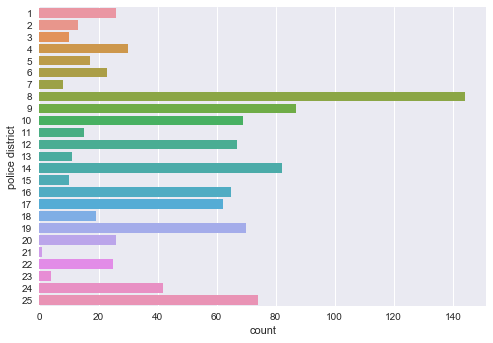

In [6]:
ax = sns.countplot(y="police district", data=df)

## 311 Requests by Type

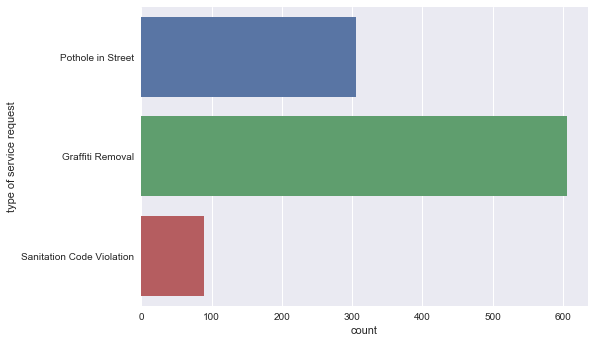

In [7]:
ax = sns.countplot(y="type of service request", data=df)

### Top Ten Community Areas by Request Count

In [8]:
df['community area name'].value_counts().head(10)

West Town          51
South Lawndale     49
Logan Square       45
Belmont Cragin     39
Avondale           33
Lower West Side    32
Portage Park       30
Brighton Park      30
Lake View          28
Chicago Lawn       28
Name: community area name, dtype: int64

In [9]:
# building a community area variable dataframe
indicators = df[['community area name','percent households below poverty', 'percent aged 16+ unemployed',
       'percent aged 25+ without high school diploma',
       'percent aged under 18 or over 64', 'per capita income ',
       'hardship index']].groupby('community area name').max()

indicators.join(df['community area name'].value_counts())

# Adding response time
response_time = df.groupby('community area name')['response time'].mean()
indicators = indicators.join(response_time)

# Adding request counts
indicators['total_requests'] = 0

request_types = df['type of service request'].unique()

for request_type in request_types:
    t = df[df['type of service request'] == request_type]
    t = t['community area name'].value_counts()
    t = t.rename('num' + request_type)
    indicators = indicators.join(t)
    indicators[t.name].fillna(0, inplace=True)
    indicators['total_requests'] = indicators['total_requests'] + indicators[t.name]
    

In [10]:
indicators

,percent households below poverty,percent aged 16+ unemployed,percent aged 25+ without high school diploma,percent aged under 18 or over 64,per capita income,hardship index,response time,total_requests,numPothole in Street,numGraffiti Removal,numSanitation Code Violation
community area name,,,,,,,,,,,
Albany Park,19.2,10.0,32.9,32.0,21323,53.0,7.000000,17.0,3.0,13.0,1.0
Archer Heights,14.1,16.5,35.9,39.2,16134,67.0,4.363636,22.0,0.0,20.0,2.0
Armour Square,40.1,16.7,34.5,38.3,16148,82.0,8.200000,5.0,2.0,3.0,0.0
Ashburn,10.4,11.7,17.7,36.9,23482,37.0,37.230769,13.0,9.0,1.0,3.0
Auburn Gresham,27.6,28.3,18.5,41.9,15528,74.0,17.666667,15.0,11.0,2.0,2.0
Austin,28.6,22.6,24.4,37.9,15957,73.0,15.625000,16.0,10.0,4.0,2.0
Avalon Park,17.2,21.1,10.6,39.3,24454,41.0,3.000000,3.0,3.0,0.0,0.0
Avondale,15.3,9.2,24.7,31.0,20039,42.0,18.969697,33.0,3.0,29.0,1.0
Belmont Cragin,18.7,14.6,37.3,37.3,15461,70.0,16.025641,39.0,9.0,27.0,3.0


### Graffiti locations

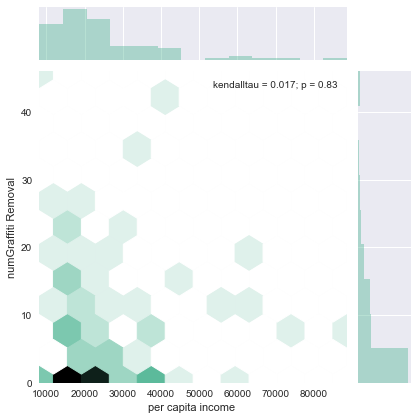

In [11]:
from scipy.stats import kendalltau
x = indicators['per capita income ']
y = indicators['numGraffiti Removal']
ax = sns.jointplot(x, y, kind="hex", stat_func=kendalltau, color="#4CB391")

In [ ]:
### Poverty and Graffiti

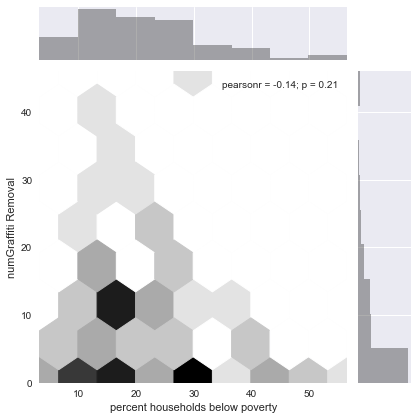

In [12]:
x = indicators['percent households below poverty']
y = indicators['numGraffiti Removal']
ax = sns.jointplot(x, y, kind="hex", color="#333333")

### Hardship and Potholes

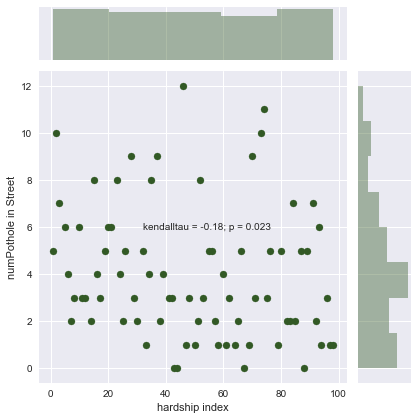

In [13]:
x = indicators['hardship index']
y = indicators['numPothole in Street']
ax = sns.jointplot(x, y, stat_func=kendalltau, color="#325925")

### Avg Response Time by Community Area (top 10)

In [14]:
indicators['response time'].sort_values(ascending=False).head(10)

community area name
Lincoln Park         1639.368421
Near South Side       202.000000
Burnside               75.000000
Dunning                52.000000
Englewood              39.666667
Ashburn                37.230769
West Elsdon            33.769231
Montclaire             31.000000
New City               29.684211
Washington Height      25.666667
Name: response time, dtype: float64

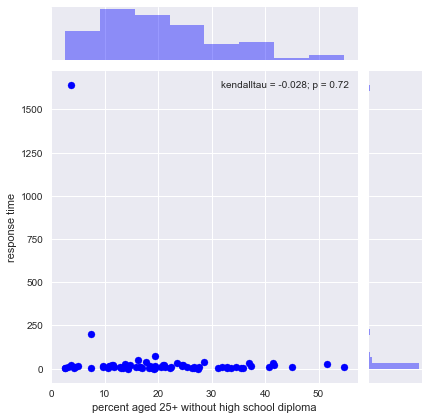

In [15]:
x = indicators['percent aged 25+ without high school diploma']
y = indicators['response time']
ax = sns.jointplot(x, y, stat_func=kendalltau, color="blue")

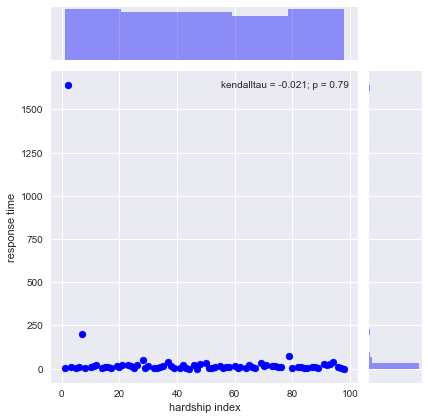

In [16]:
x = indicators['hardship index']
y = indicators['response time']
ax = sns.jointplot(x, y, stat_func=kendalltau, color="blue")

### Types over time

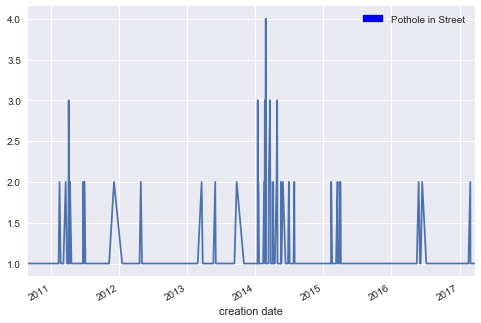

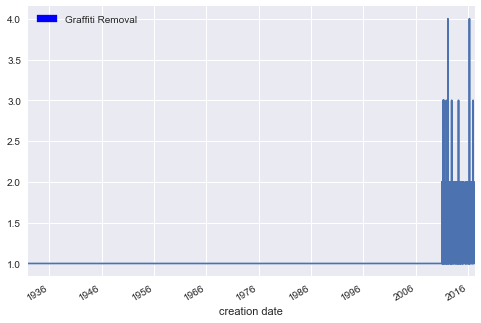

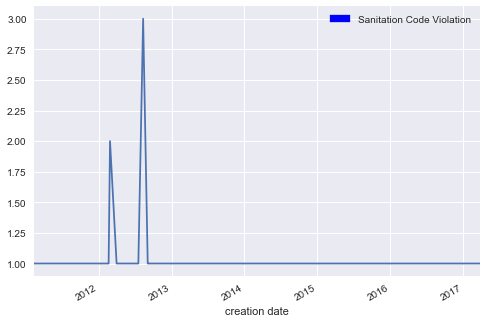

In [17]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
for t in df['type of service request'].unique():
    ax = df[df["type of service request"] == t][['creation date', "type of service request"]].groupby('creation date').count().plot()
    p = mpatches.Patch(color='blue', label=t)
    plt.legend(handles=[p])
plt.show()

### Summary of findings

- Graffiti is the most frequent service request. Graffiti removal has been consistently reported in the data we've analyzed.

- Graffiti request tend to be in lower income areas, either by per capita income or households in poverty

- There doesn't appear to be any strong linear relationship between hardship index and potholes

- Potholes were an mostly an issue in 2014. They are reported less currently. Sanitation and Abandon Buildings were not reported often

- There doesn't appear to be any strong linear relationship between hardship or adults without a HS diploma and response time 

# Problem 2 - Data Augmentation with ACS

In [18]:
# storing
old = df

In [19]:
import requests
from requests.auth import HTTPBasicAuth

API_KEY = '9032d3c94c7f4afe905da54f889af02a6b51f63f'
request_url = "http://citysdk.commerce.gov"

variables = ['income','population','poverty','median_contract_rent','education_bachelors','poverty_family']

def acs_data (zip_code):
    request_obj = {
        'level': 'tract',
        'zip': int(zip_code),
        'sublevel': False,
        'api': 'acs5',
        'year': 2014,
        'variables': variables
        }

    data = None
    
    response = requests.post(request_url, auth=HTTPBasicAuth(API_KEY, None), json=request_obj)
    if response:
        data = response.json()
        data = data['features'][0]['properties']

    return data

In [20]:
# pull data by from zip code
codes = df[['zip code']]
codes = codes.drop_duplicates()

acs = codes.apply(acs_data, axis=1)
acs = acs.apply(pd.Series)

In [21]:
acs_ = acs
# humanize
columns = ['B01003_001E', 'B15003_022E', 'B17001_002E','B17012_002E', 'B19013_001E', 'B25058_001E']
ref = {"B15003_022E": "education_bachelors",
        "B19013_001E":   "income",
        "B25058_001E":   "median_contract_rent",
        "B01003_001E":   "population",
        "B17001_002E":   "poverty",
        "B17012_002E":   "poverty_family"}
new_name = [ref[key] for key in columns]
acs = acs[columns]
acs.columns = new_name

In [22]:
# combine zip with acs
acs = pd.concat([acs,codes], axis=1)

In [23]:
# combine df with acs on zip
df = df.merge(acs, on='zip code')

In [48]:
# combine all indicators
new_indicators = df.groupby('community area name').max()
new_indicators = new_indicators.merge(indicators)

### Type by Community Area

In [ ]:
g = sns.FacetGrid(df, col="type of service request")
ax = g.map(plt.hist, "community area")

#### What types of blocks get “Vacant and Abandoned Buildings Reported”?
I don't have any data in my sample on these

#### What types of blocks get “Sanitation Code Complaints”?
community area 47, near the Chatam neighborhood, which has lower incomes and 18% unemployment

#### Does that change over time in the data you collected?
There is a consitent bimodal distribution over the years, but it has changed slightly.

#### What is the difference in blocks that get “Vacant and Abandoned Buildings Reported” vs “Sanitation Code Complaints”?
I don't have any data in my sample on these

In [ ]:
###

In [49]:
df['type of service request'].unique()

array(['Pothole in Street', 'Graffiti Removal', 'Sanitation Code Violation'], dtype=object)

In [45]:
new_indicators[new_indicators['community area'] == 47]

,community area,completion date,creation date,latitude,location,longitude,number of potholes filled on block,police district,service request number,service request type,...,percent aged 16+ unemployed,percent aged 25+ without high school diploma,percent aged under 18 or over 64,per capita income,hardship index,year,total_requests,numPothole in Street,numGraffiti Removal,numSanitation Code Violation
0,47,2014-08-02,2014-05-19,41.734707,"(41.73470701625012, -87.59735991511906)",-87.59736,30.0,4,14-00738935,NaN,...,18.6,19.3,42.7,12515,79.0,2014,1.0,1.0,0.0,0.0


### Sanitation Code Violations over time

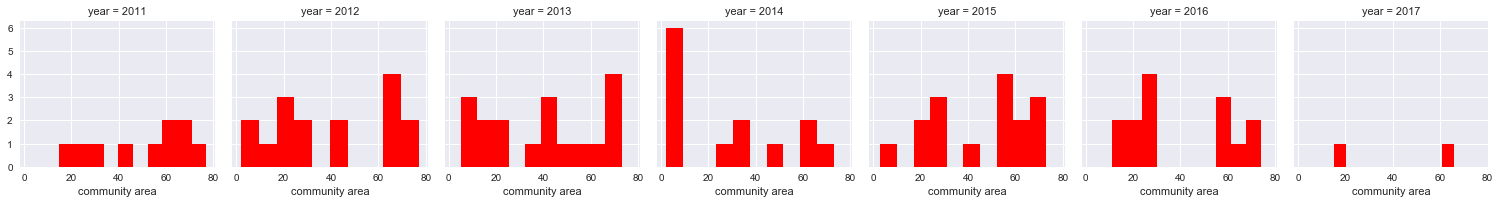

In [51]:
data = df[df['type of service request'] == 'Sanitation Code Violation']
g = sns.FacetGrid(data, col="year")
g = g.map(plt.hist, "community area", color="r")

# Problem 3

Assume you are running the 311 call center for Chicago. You get a call from 7500 S Wolcott Ave.

Of the four types of requests you have data for, which request type is the most likely given the call came from 7500 S Wolcott Ave? What are the probabilities for each type of request?
Let’s now assume that a call comes in about Graffiti Removal. Which is more likely – that the call came from Lawndale or Uptown? How much more or less likely is it to be from Lawndale versus Uptown?
Now assume that you don’t have access to all the raw data and you know the following things:

There are a total of 1000 calls, 600 from Englewood and 400 from Uptown. 
Of the 600 calls from Englewood, 100 of them are about Graffiti Removal. 
Of the 400 calls from Uptown, 160 are about Graffiti Removal. 

If a call comes about Graffiti Removal, how much more/less likely is it 
that the call came from Englewood versus Uptown? 

In [ ]:
total = indicators['numGraffiti Removal'].sum()
eng_prob = (indicators[indicators.index == 'Englewood']['numGraffiti Removal'] / total).values
lawn_prob = (indicators[indicators.index == 'North Lawndale']['numGraffiti Removal'] / total).values
print("engleside prob = ", eng_prob)
print("lawndale prob = ", lawn_prob)

### Answer:
Given the sample data, they have an equal chance of happening. 

With the synthetic data, the prob a call is 60% and 40% for Englewood and Uptown.
- Prob(Englewood | Graffiti) =  100/600 x 600/1000 = 10%
- Prob(Uptown | Graffiti) = 160/400 x 400/1000 = 16%